In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import seaborn as sns
import joblib
import pickle

In [2]:
ipl = pd.read_csv("ipl.csv")

In [3]:
ipl.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [4]:
ipl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76014 entries, 0 to 76013
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mid             76014 non-null  int64  
 1   date            76014 non-null  object 
 2   venue           76014 non-null  object 
 3   bat_team        76014 non-null  object 
 4   bowl_team       76014 non-null  object 
 5   batsman         76014 non-null  object 
 6   bowler          76014 non-null  object 
 7   runs            76014 non-null  int64  
 8   wickets         76014 non-null  int64  
 9   overs           76014 non-null  float64
 10  runs_last_5     76014 non-null  int64  
 11  wickets_last_5  76014 non-null  int64  
 12  striker         76014 non-null  int64  
 13  non-striker     76014 non-null  int64  
 14  total           76014 non-null  int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 8.7+ MB


## Data Preprocessing

Removing unwanted colulmns


In [5]:
col_remove = ['mid', 'striker', 'non-striker', 'batsman', 'bowler']
ipl.drop(col_remove, axis=1, inplace=True)

ipl['date'] = ipl['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [6]:
ipl['bat_team'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Deccan Chargers', 'Kings XI Punjab',
       'Royal Challengers Bangalore', 'Delhi Daredevils',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant'], dtype=object)

In [7]:
ipl['bowl_team'].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Mumbai Indians', 'Chennai Super Kings', 'Deccan Chargers',
       'Pune Warriors', 'Kochi Tuskers Kerala', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant'], dtype=object)

From Deccan Chargers we are replacing the data to Hyderabad Sunrisers.


In [8]:
ipl['bat_team'] = ipl['bat_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
ipl['bowl_team'] = ipl['bowl_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

In [9]:
ipl['bat_team'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Sunrisers Hyderabad', 'Kings XI Punjab',
       'Royal Challengers Bangalore', 'Delhi Daredevils',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Gujarat Lions', 'Rising Pune Supergiant'], dtype=object)

In [10]:
#sticking with just the teams that are currently available
consistent_teams = ['Chennai Super Kings', 'Delhi Daredevils', 
                    'Kings XI Punjab', 'Kolkata Knight Riders', 
                    'Mumbai Indians', 'Rajasthan Royals', 
                    'Royal Challengers Bangalore', 'Sunrisers Hyderabad']
print("Before removing inconsistent teams: {}".format(ipl.shape))
ipl = ipl[(ipl['bat_team'].isin(consistent_teams)) & (ipl['bowl_team'].isin(consistent_teams))]
print("After removing inconsistent teams: {}".format(ipl.shape))

#removing first 5 overs of data because it is too early to predict

ipl = ipl[ipl['overs'] >= 5]

print("After dropping overs before 5: {}".format(ipl.shape))

Before removing inconsistent teams: (76014, 10)
After removing inconsistent teams: (62464, 10)
After dropping overs before 5: (46560, 10)


Removing inconsistent venues from the dataset

### Model Building and Hyper Parameter Tuning

In [11]:
def f(x):
    if x=='M Chinnaswamy Stadium':
        return 'M Chinnaswamy Stadium, Bangalore'
    elif x=='Feroz Shah Kotla':
        return 'Feroz Shah Kotla, Delhi'
    elif x=='Wankhede Stadium':
        return 'Wankhede Stadium, Mumbai'
    elif x=='Sawai Mansingh Stadium':
        return 'Sawai Mansingh Stadium, Jaipur'
    elif x=='Eden Gardens':
        return 'Eden Gardens, Kolkata'
    elif x=='Dr DY Patil Sports Academy':
        return 'Dr DY Patil Sports Academy, Mumbai'
    elif x=='Himachal Pradesh Cricket Association Stadium':
        return 'Himachal Pradesh Cricket Association Stadium, Dharamshala'
    elif x=='Subrata Roy Sahara Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Shaheed Veer Narayan Singh International Stadium':
        return 'Raipur International Cricket Stadium, Raipur'
    elif x=='JSCA International Stadium Complex':
        return 'JSCA International Stadium Complex, Ranchi'
    elif x=='Maharashtra Cricket Association Stadium':
        return 'Maharashtra Cricket Association Stadium, Pune'
    elif x=='Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium':
        return 'ACA-VDCA Stadium, Visakhapatnam'
    elif x=='Punjab Cricket Association IS Bindra Stadium, Mohali':
        return 'Punjab Cricket Association Stadium, Mohali'
    elif x=='Holkar Cricket Stadium':
        return 'Holkar Cricket Stadium, Indore'
    elif x=='Sheikh Zayed Stadium':
        return 'Sheikh Zayed Stadium, Abu-Dhabi'
    elif x=='Sharjah Cricket Stadium':
        return 'Sharjah Cricket Stadium, Sharjah'
    elif x=='Dubai International Cricket Stadium':
        return 'Dubai International Cricket Stadium, Dubai'
    elif x=='Barabati Stadium':
        return 'Barabati Stadium, Cuttack'
    else:
        return x

ignored_stadiums = ['Newlands', "St George's Park",
                    'Kingsmead', 'SuperSport Park', 'Buffalo Park',
                    'New Wanderers Stadium', 'De Beers Diamond Oval',
                    'OUTsurance Oval', 'Brabourne Stadium']

ipl = ipl[True^(ipl['venue'].isin(ignored_stadiums))]
ipl['venue'] = ipl['venue'].apply(f)

df_new = pd.get_dummies(data=ipl,columns=['venue','bat_team','bowl_team'])

df_new = df_new[['date','venue_ACA-VDCA Stadium, Visakhapatnam',
       'venue_Barabati Stadium, Cuttack', 'venue_Dr DY Patil Sports Academy, Mumbai',
       'venue_Dubai International Cricket Stadium, Dubai',
       'venue_Eden Gardens, Kolkata', 'venue_Feroz Shah Kotla, Delhi',
       'venue_Himachal Pradesh Cricket Association Stadium, Dharamshala',
       'venue_Holkar Cricket Stadium, Indore',
       'venue_JSCA International Stadium Complex, Ranchi',
       'venue_M Chinnaswamy Stadium, Bangalore',
       'venue_MA Chidambaram Stadium, Chepauk',
       'venue_Maharashtra Cricket Association Stadium, Pune',
       'venue_Punjab Cricket Association Stadium, Mohali',
       'venue_Raipur International Cricket Stadium, Raipur',
       'venue_Rajiv Gandhi International Stadium, Uppal',
       'venue_Sardar Patel Stadium, Motera',
       'venue_Sawai Mansingh Stadium, Jaipur',
       'venue_Sharjah Cricket Stadium, Sharjah',
       'venue_Sheikh Zayed Stadium, Abu-Dhabi',
       'venue_Wankhede Stadium, Mumbai','bat_team_Chennai Super Kings',
       'bat_team_Delhi Daredevils', 'bat_team_Kings XI Punjab',
       'bat_team_Kolkata Knight Riders', 'bat_team_Mumbai Indians',
       'bat_team_Rajasthan Royals', 'bat_team_Royal Challengers Bangalore',
       'bat_team_Sunrisers Hyderabad','bowl_team_Chennai Super Kings',
       'bowl_team_Delhi Daredevils', 'bowl_team_Kings XI Punjab',
       'bowl_team_Kolkata Knight Riders', 'bowl_team_Mumbai Indians',
       'bowl_team_Rajasthan Royals', 'bowl_team_Royal Challengers Bangalore',
       'bowl_team_Sunrisers Hyderabad','runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5',
       'total']]

df_new.reset_index(inplace=True)
df_new.drop('index',inplace=True,axis=1)

df_new.head(2)

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,0,5.1,59,0,222
1,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,61,1,5.2,59,1,222


In [12]:
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(df_new[['runs', 'wickets','overs', 'runs_last_5', 'wickets_last_5']])

In [13]:
scaled_cols

array([[-0.83271858, -1.59826842, -1.66896847,  1.72433097, -1.23655361],
       [-0.83271858, -1.06968042, -1.64581802,  1.72433097, -0.29423267],
       [-0.83271858, -1.06968042, -1.62266757,  1.72433097, -0.29423267],
       ...,
       [ 0.28836491,  3.15902365,  1.3868904 , -0.9555844 ,  2.53273013],
       [ 0.28836491,  3.15902365,  1.41004084, -1.30137993,  2.53273013],
       [ 0.28836491,  3.68761165,  1.43319129, -1.38782882,  3.47505106]])

In [14]:
scaled_cols = pd.DataFrame(scaled_cols,columns=['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'])
df_new.drop(['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'],axis=1,inplace=True)
df_new = pd.concat([df_new,scaled_cols],axis=1)

In [15]:
df_new

,date,"venue_ACA-VDCA Stadium, Visakhapatnam","venue_Barabati Stadium, Cuttack","venue_Dr DY Patil Sports Academy, Mumbai","venue_Dubai International Cricket Stadium, Dubai","venue_Eden Gardens, Kolkata","venue_Feroz Shah Kotla, Delhi","venue_Himachal Pradesh Cricket Association Stadium, Dharamshala","venue_Holkar Cricket Stadium, Indore","venue_JSCA International Stadium Complex, Ranchi",...,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad,total,runs,wickets,overs,runs_last_5,wickets_last_5
0,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832719,-1.598268,-1.668968,1.724331,-1.236554
1,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832719,-1.069680,-1.645818,1.724331,-0.294233
2,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832719,-1.069680,-1.622668,1.724331,-0.294233
3,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832719,-1.069680,-1.599517,1.724331,-0.294233
4,2008-04-18,0,0,0,0,0,0,0,0,0,...,0,0,1,0,222,-0.832719,-1.069680,-1.576367,1.637882,-0.294233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40534,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.263994,3.159024,1.340590,-0.869136,2.532730
40535,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.288365,3.159024,1.363740,-0.869136,2.532730
40536,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.288365,3.159024,1.386890,-0.955584,2.532730
40537,2017-05-19,0,0,0,0,0,0,0,0,0,...,1,0,0,0,107,0.288365,3.159024,1.410041,-1.301380,2.532730


In [16]:
X_train = df_new.drop('total',axis=1)[df_new['date'].dt.year<=2016]
X_test = df_new.drop('total',axis=1)[df_new['date'].dt.year>=2017]

X_train.drop('date',inplace=True,axis=1)
X_test.drop('date',inplace=True,axis=1)


y_train = df_new[df_new['date'].dt.year<=2016]['total'].values
y_test = df_new[df_new['date'].dt.year>=2017]['total'].values

In [17]:
X_train.shape

(37761, 41)

In [18]:
X_test.shape

(2778, 41)

### Ridge Regressor

In [19]:
ridge = Ridge()
parameters={'alpha':[1e-3,1e-2,1,5,10,20]}
ridge_regressor = RandomizedSearchCV(ridge,parameters,cv=10,scoring='neg_mean_squared_error')
model = ridge_regressor.fit(X_train,y_train)

C:\Users\donjo\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [20]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

prediction_r = ridge_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))
print(f'r2 score of ridge : {r2_score(y_test,prediction_r)}')

{'alpha': 20}
-337.6523649599119
MAE: 12.598775706219094
MSE: 275.9698789039512
RMSE: 16.612341162640238
r2 score of ridge : 0.7276267194118747


C:\Users\donjo\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

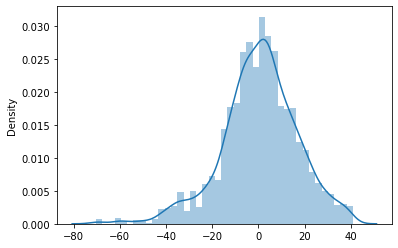

In [23]:
sns.distplot(y_test-prediction_r)

In [28]:
joblib.dump(ridge_regressor,'iplmodel_ridge.sav')

['iplmodel_ridge.sav']

In [29]:
model.score(X_test, y_test)

-275.9698789039512